In [1]:
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import PIL
from tensorflow.keras.layers import Dense,Flatten,Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam ,SGD
from sklearn.metrics import mean_squared_error as MSE_SKL
from sklearn.metrics import mean_absolute_error as MAE_SKL
from tensorflow.keras.metrics import mean_absolute_error as MAE_TF
from tensorflow.keras.regularizers import L2
from keras.models import load_model
from sklearn.model_selection import train_test_split
from keras.models import Model
import os

In [2]:
# Check if tensorflow detectects the gpu or not
if tf.test.gpu_device_name():
    print("Gpu available: {}".format(tf.test.gpu_device_name()))
else:
    print("Tensor Flow has not detected the gpu")

Gpu available: /device:GPU:0


In [3]:
print(plt.style.available)
plt.style.use('ggplot')

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [4]:
# Function to preprocess the image
def preprocess_image(image):
    # Enhance edges using adaptive histogram equalization (CLAHE)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_image = clahe.apply(image)
    
    # Apply a bilateral filter to remove noise while keeping edges sharp
    filtered_image = cv2.bilateralFilter(enhanced_image, d=9, sigmaColor=75, sigmaSpace=75)
    enhanced_image = cv2.cvtColor(enhanced_image,cv2.COLOR_GRAY2RGB)
    filtered_image = cv2.cvtColor(filtered_image,cv2.COLOR_GRAY2RGB)
    return enhanced_image, filtered_image

In [5]:
train_inputImg = pd.read_csv('Data/train_data.csv', delimiter=',')

train_images = []
train_images_rgb_blured = []

train_images_hsv = []
train_images_hsv_blured  = []

train_coords=[]


train_images_enhanced = []
train_images_filtered = []


for row in train_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    train_x_1_coord = []
    train_y_1_coord = []
    for i in range(0,len(coords)-1,2):
        train_x_1_coord.append((coords[i]))
        train_x_1_coord.append((coords[i+1]))
    train_coords.append(np.array(train_x_1_coord))
    
    gray_image = cv2.imread('Data/ROI images/' + image_object[0],cv2.IMREAD_GRAYSCALE ) 
    #gray_resized_image = cv2.resize(gray_image,(250,600))
    
    
    #rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    rgb_resized_image = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    enhanced_image, filtered_image = preprocess_image(gray_image)
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))
    
    
    train_images_enhanced.append(enhanced_image)
    train_images_filtered.append(filtered_image)
    train_images.append(rgb_resized_image)
    train_images_rgb_blured.append(blured_rgb_resized_image)
    
    train_images_hsv.append(hsv_resized_image)
    train_images_hsv_blured.append(blured_hsv_resized_image)
    

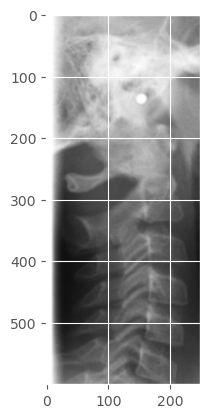

In [6]:
blur = cv2.blur(train_images[0],(3,3))
plt.imshow(blur)

In [7]:
print("Type of train_images", type(train_images))
print("Shape of Training Images",(np.array(train_images).shape),"\n")

print("Type of train_images", type(train_images_hsv))
print("Shape of Training Images",(np.array(train_images_hsv).shape),"\n")

print("Type of train_coords", type(train_coords))
print("Shape of train_coords",(np.array(train_coords).shape))

Type of train_images <class 'list'>
Shape of Training Images (366, 600, 250, 3) 

Type of train_images <class 'list'>
Shape of Training Images (366, 600, 250, 3) 

Type of train_coords <class 'list'>
Shape of train_coords (366, 38)


In [8]:
val_inputImg = pd.read_csv('Data/test_data.csv', delimiter=',')
val_images = []
val_images_rgb_blured = []
val_images_hsv_blured  = []

val_images_enhanced = []
val_images_filtered = []


val_images_hsv = []
val_images_rgb_blured = []
val_images_hsv_blured  = []

val_coords = []

count = 1

for row in val_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    train_x_1_coord = []
    train_y_1_coord = []
    val_x_1_coord = []
    val_y_1_coord = []
    
    gray_image = cv2.imread('Data/ROI images/' + image_object[0],cv2.IMREAD_GRAYSCALE ) 
    enhanced_image, filtered_image = preprocess_image(gray_image)
    #gray_resized_image = cv2.resize(gray_image,(250,600))
    #rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    rgb_resized_image = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))
    
    if count <= 50:
            train_images.append(rgb_resized_image)
            train_images_hsv.append(hsv_resized_image)
            train_images_rgb_blured.append(blured_rgb_resized_image)
            train_images_hsv_blured.append(blured_hsv_resized_image)
            train_images_enhanced.append(enhanced_image)
            train_images_filtered.append(filtered_image)

    else:
            val_images.append(rgb_resized_image)
            val_images_hsv.append(hsv_resized_image)
            val_images_rgb_blured.append(blured_rgb_resized_image)
            val_images_hsv_blured.append(blured_hsv_resized_image)
            val_images_enhanced.append(enhanced_image)
            val_images_filtered.append(filtered_image)
            
    for i in range(0,len(coords)-1,2):
        
        if count <= 50:
            train_x_1_coord.append((coords[i]))
            train_x_1_coord.append((coords[i+1]))
        
        else:
            val_x_1_coord.append((coords[i]))
            val_x_1_coord.append((coords[i+1]))
    if count<=50:
        train_coords.append(np.array(train_x_1_coord))
    else:
        val_coords.append(np.array(val_x_1_coord))

    
    count += 1
    

In [9]:
print("Type of val_images", type(val_images))
print("Shape of val_images ",(np.array(val_images).shape),"\n")

print("Type of val_images", type(val_images_hsv))
print("Shape of val_images ",(np.array(val_images_hsv).shape),"\n")

print("Type of val_coords", type(val_coords))
print("Shape of val_coords",(np.array(val_coords).shape))

Type of val_images <class 'list'>
Shape of val_images  (17, 600, 250, 3) 

Type of val_images <class 'list'>
Shape of val_images  (17, 600, 250, 3) 

Type of val_coords <class 'list'>
Shape of val_coords (17, 38)


In [40]:
test_inputImg = pd.read_csv('Data/test_data.csv', delimiter=',')
test_images = []
test_images_rgb_blured = []

test_images_hsv = []
test_images_hsv_blured = []


test_images_enhanced = []
test_images_filtered = []

test_coords = []



for row in test_inputImg.values:
    image_object = list(row)
    coords = image_object[1:]
    test_x_1_coord = []
    for i in range(0,len(coords)-1,2):
        test_x_1_coord.append((coords[i]))
        test_x_1_coord.append((coords[i+1]))
    test_coords.append(np.array(test_x_1_coord))
    #print('Data/ROI images/' + image_object[0])
    gray_image = cv2.imread('Data/ROI images/' + image_object[0],cv2.IMREAD_GRAYSCALE )
    #cv2.imshow("img",gray_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    enhanced_image, filtered_image = preprocess_image(gray_image)
    #gray_resized_image = cv2.resize(gray_image,(250,600))
    
    #rgb_resized_image = cv2.cvtColor(gray_resized_image,cv2.COLOR_GRAY2RGB)
    rgb_resized_image = cv2.cvtColor(gray_image,cv2.COLOR_GRAY2RGB)
    blured_rgb_resized_image = cv2.blur(rgb_resized_image,(3,3))
    
    hsv_resized_image = cv2.cvtColor(rgb_resized_image, cv2.COLOR_BGR2HSV)
    blured_hsv_resized_image = cv2.blur(hsv_resized_image ,(3,3))

    

    test_images.append(rgb_resized_image)
    test_images_rgb_blured.append(blured_rgb_resized_image)

    test_images_enhanced.append(enhanced_image)
    test_images_filtered.append(filtered_image)

    test_images_hsv.append(hsv_resized_image)
    test_images_hsv_blured.append(blured_hsv_resized_image)

Data/ROI images/LC (475).jpg
Data/ROI images/LC (476).jpg
Data/ROI images/LC (477).jpg
Data/ROI images/LC (478).jpg
Data/ROI images/LC (479).jpg
Data/ROI images/LC (48).jpg
Data/ROI images/LC (480).jpg
Data/ROI images/LC (481).jpg
Data/ROI images/LC (482).jpg
Data/ROI images/LC (484).jpg
Data/ROI images/LC (485).jpg
Data/ROI images/LC (486).jpg
Data/ROI images/LC (487).jpg
Data/ROI images/LC (488).jpg
Data/ROI images/LC (489).jpg
Data/ROI images/LC (49).jpg
Data/ROI images/LC (491).jpg
Data/ROI images/LC (492).jpg
Data/ROI images/LC (494).jpg
Data/ROI images/LC (495).jpg
Data/ROI images/LC (497).jpg
Data/ROI images/LC (498).jpg
Data/ROI images/LC (499).jpg
Data/ROI images/LC (50).jpg
Data/ROI images/LC (500).jpg
Data/ROI images/LC (51).jpg
Data/ROI images/LC (52).jpg
Data/ROI images/LC (53).jpg
Data/ROI images/LC (54).jpg
Data/ROI images/LC (55).jpg
Data/ROI images/LC (56).jpg
Data/ROI images/LC (57).jpg
Data/ROI images/LC (58).jpg
Data/ROI images/LC (59).jpg
Data/ROI images/LC (60).jp

In [11]:
print("Type of test_images", type(test_images))
print("Shape of test_images ",(np.array(test_images).shape),"\n")

print("Type of test_images", type(test_images_hsv))
print("Shape of test_images ",(np.array(test_images_hsv).shape),"\n")

print("Type of test_coords", type(test_coords))
print("Shape of test_coords",(np.array(test_coords).shape))

Type of test_images <class 'list'>
Shape of test_images  (67, 600, 250, 3) 

Type of test_images <class 'list'>
Shape of test_images  (67, 600, 250, 3) 

Type of test_coords <class 'list'>
Shape of test_coords (67, 38)


In [12]:
print("********* Training Set *********")
print("Shape of Training Images",(np.array(train_images).shape),"\n")
print("Shape of Training Images",(np.array(train_images_hsv).shape),"\n")
print("Shape of Training  Images",(np.array(train_images_enhanced).shape),"\n")
print("Shape of Training Images",(np.array(train_images_filtered).shape),"\n")
print("Shape of train_coords",(np.array(train_coords).shape),"\n")




print("********* Validation Set *********")
print("Shape of val_images ",(np.array(val_images).shape),"\n")
print("Shape of test_images ",(np.array(val_images_hsv).shape),"\n")
print("Shape of test_images ",(np.array(val_images_enhanced).shape),"\n")
print("Shape of test_images ",(np.array(val_images_filtered).shape),"\n")
print("Shape of val_coords",(np.array(val_coords).shape),"\n")

print("********* Test Set *********")
print("Shape of test_images ",(np.array(test_images).shape),"\n")
print("Shape of test_images ",(np.array(test_images_hsv).shape),"\n")
print("Shape of test_images ",(np.array(test_images_enhanced).shape),"\n")
print("Shape of test_images ",(np.array(test_images_filtered).shape),"\n")
print("Shape of test_coords",(np.array(test_coords).shape))

********* Training Set *********
Shape of Training Images (416, 600, 250, 3) 

Shape of Training Images (416, 600, 250, 3) 

Shape of Training  Images (416, 600, 250, 3) 

Shape of Training Images (416, 600, 250, 3) 

Shape of train_coords (416, 38) 

********* Validation Set *********
Shape of val_images  (17, 600, 250, 3) 

Shape of test_images  (17, 600, 250, 3) 

Shape of test_images  (17, 600, 250, 3) 

Shape of test_images  (17, 600, 250, 3) 

Shape of val_coords (17, 38) 

********* Test Set *********
Shape of test_images  (67, 600, 250, 3) 

Shape of test_images  (67, 600, 250, 3) 

Shape of test_images  (67, 600, 250, 3) 

Shape of test_images  (67, 600, 250, 3) 

Shape of test_coords (67, 38)


In [13]:
train_images_stacked = np.stack(train_images, axis=0)
train_images_rgb_blured_stacked = np.stack(train_images_rgb_blured, axis=0)

train_images_enhanced_stacked = np.stack(train_images_enhanced, axis=0)
train_images_filtered_stacked =  np.stack(train_images_filtered, axis=0)

train_images_hsv_stacked = np.stack(train_images_hsv, axis=0)
train_images_hsv_blured_stacked = np.stack(train_images_hsv_blured, axis=0)



train_labels = np.array(train_coords)

In [14]:
print((train_labels[17]))

[110. 439. 140. 436. 172. 448. 111. 454. 142. 465. 172. 478. 108. 489.
 177. 504. 106. 525. 139. 526. 174. 535. 108. 536. 140. 554. 170. 566.
 105. 571. 169. 594.  99. 607. 129. 614. 156. 626.]


In [43]:
for img_num in range(len(train_images_stacked)):
    #img_num =17
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][0]),int(train_labels[img_num][1])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][2]),int(train_labels[img_num][3])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][4]),int(train_labels[img_num][5])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][6]),int(train_labels[img_num][7])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][8]),int(train_labels[img_num][9])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][10]),int(train_labels[img_num][11])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][12]),int(train_labels[img_num][13])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][14]),int(train_labels[img_num][15])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][16]),int(train_labels[img_num][17])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][18]),int(train_labels[img_num][19])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][20]),int(train_labels[img_num][21])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][22]),int(train_labels[img_num][23])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][24]),int(train_labels[img_num][25])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][26]),int(train_labels[img_num][27])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][28]),int(train_labels[img_num][29])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][30]),int(train_labels[img_num][31])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][32]),int(train_labels[img_num][33])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][34]),int(train_labels[img_num][35])), 2, (255,0,0),-1)
    img = cv2.circle(train_images_stacked[img_num], (int(train_labels[img_num][36]),int(train_labels[img_num][37])), 2, (255,0,0),-1)
    #plt.imshow(img)
    cv2.imshow("img",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()


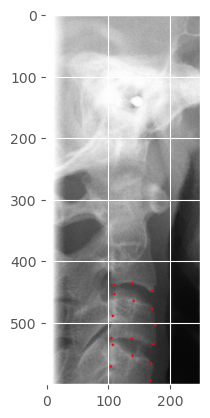

In [16]:
img_ = cv2.circle(train_images_stacked[img_num], (250,600), 2, (255,0,0),-1)
plt.imshow(img_)

In [17]:
val_images_stacked= np.stack(val_images, axis=0)
val_images_rgb_blured_stacked= np.stack(val_images_rgb_blured, axis=0)


val_images_hsv_stacked= np.stack(val_images_hsv, axis=0)
val_images_hsv_blured_stacked= np.stack(val_images_hsv_blured, axis=0)

val_images_enhanced_stacked= np.stack(val_images_enhanced, axis=0)
val_images_filtered_stacked= np.stack(val_images_filtered, axis=0)

val_labels = np.array(val_coords)

val_data = (val_images_stacked,val_labels)
val_data_rgb_blured = (val_images_rgb_blured_stacked,val_labels)                                        

val_data_enhanced = (val_images_enhanced_stacked,val_labels)
val_data_filtered = (val_images_filtered_stacked,val_labels)

val_data_hsv = (val_images_hsv_stacked,val_labels)
val_data_hsv_blured = (val_images_hsv_blured_stacked,val_labels)


In [18]:
test_images_stacked= np.stack(test_images, axis=0)
test_images_rgb_blured_stacked= np.stack(test_images_rgb_blured, axis=0)

test_images_hsv_stacked= np.stack(test_images_hsv, axis=0)
test_images_hsv_blured_stacked= np.stack(test_images_hsv_blured, axis=0)

test_images_enhanced_stacked= np.stack(test_images_enhanced, axis=0)
test_images_filtered_stacked= np.stack(test_images_filtered, axis=0)


test_labels = np.array(test_coords)

In [41]:
for img_num in range(len(test_images_stacked)):
    #img_num =0
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][0]),int(test_labels[img_num][1])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][2]),int(test_labels[img_num][3])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][4]),int(test_labels[img_num][5])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][6]),int(test_labels[img_num][7])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][8]),int(test_labels[img_num][9])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][10]),int(test_labels[img_num][11])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][12]),int(test_labels[img_num][13])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][14]),int(test_labels[img_num][15])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][16]),int(test_labels[img_num][17])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][18]),int(test_labels[img_num][19])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][20]),int(test_labels[img_num][21])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][22]),int(test_labels[img_num][23])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][24]),int(test_labels[img_num][25])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][26]),int(test_labels[img_num][27])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][28]),int(test_labels[img_num][29])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][30]),int(test_labels[img_num][31])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][32]),int(test_labels[img_num][33])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][34]),int(test_labels[img_num][35])), 2, (255,0,0),-1)
    img = cv2.circle(test_images_stacked[img_num], (int(test_labels[img_num][36]),int(test_labels[img_num][37])), 2, (255,0,0),-1)
    #plt.imshow(img)
    cv2.imshow("img",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()



In [20]:
print("********* Stacked Training Set *********")
print("Type of train_images_stacked",(type(train_images_stacked)))
print("Shape of train_images_stacked",((train_images_stacked).shape))
print("Shape of train_images_rgb_blured_stacked",((train_images_rgb_blured_stacked).shape))
print("Shape of train_images_hsv_blured_stacked",((train_images_hsv_blured_stacked).shape))
print("Shape of train_images_enhanced_stacked",((train_images_enhanced_stacked).shape))
print("Shape of train_images_filtered_stacked",((train_images_filtered_stacked).shape))
print("Type of train_labels",(type(train_labels)))
print("Shape of train_labels",((train_labels).shape),"\n")

print("********* Stacked Validation Set *********")
print("Shape of val_images_stacked ",((val_images_stacked).shape))
print("Shape of val_images_enhanced_stacked ",((val_images_enhanced_stacked).shape))
print("Shape of val_images_filtered_stacked ",((val_images_filtered_stacked).shape))
print("Shape of val_labels",((val_labels).shape))
print("Val_datet => (val_labels,val_labels)")
print("Type of val_data",(type(val_data)),"\n")

print("********* Stacked Test Set *********")
print("Type of test_labels",(type(test_labels)))
print("Shape of test_images_stacked ",((test_images_stacked).shape))
print("Shape of test_images_enhanced_stacked ",((test_images_enhanced_stacked).shape))
print("Shape of test_images_filtered_stacked ",((test_images_filtered_stacked).shape))
print("Type of test_labels",(type(test_labels)))
print("Shape of test_labels",((test_labels).shape))

********* Stacked Training Set *********
Type of train_images_stacked <class 'numpy.ndarray'>
Shape of train_images_stacked (416, 600, 250, 3)
Shape of train_images_rgb_blured_stacked (416, 600, 250, 3)
Shape of train_images_hsv_blured_stacked (416, 600, 250, 3)
Shape of train_images_enhanced_stacked (416, 600, 250, 3)
Shape of train_images_filtered_stacked (416, 600, 250, 3)
Type of train_labels <class 'numpy.ndarray'>
Shape of train_labels (416, 38) 

********* Stacked Validation Set *********
Shape of val_images_stacked  (17, 600, 250, 3)
Shape of val_images_enhanced_stacked  (17, 600, 250, 3)
Shape of val_images_filtered_stacked  (17, 600, 250, 3)
Shape of val_labels (17, 38)
Val_datet => (val_labels,val_labels)
Type of val_data <class 'tuple'> 

********* Stacked Test Set *********
Type of test_labels <class 'numpy.ndarray'>
Shape of test_images_stacked  (67, 600, 250, 3)
Shape of test_images_enhanced_stacked  (67, 600, 250, 3)
Shape of test_images_filtered_stacked  (67, 600, 250,

In [21]:
def mean_radial_error_landmark(x_true,y_true,x_pred,y_pred):
    delta_x_2 =  np.power( ( np.subtract(x_true , x_pred) ) , 2) #(2,4)
    delta_y_2 =  np.power( ( np.subtract(y_true, y_pred ) ) , 2) #(2,4)

    radial_error_lm_ex = np.sqrt(np.add(delta_x_2,delta_y_2)) #(2,4)

#     print(radial_error_lm_ex)

    radial_error_lm = np.sum(radial_error_lm_ex, axis = 0,keepdims=True) #(1,4)
#     print(radial_error_lm)

    mean_radial_error_lm = radial_error_lm / x_true.shape[0]
#     print(x_true.shape[0])
    
    return radial_error_lm_ex,mean_radial_error_lm

In [22]:
pretrained_model2= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(600,250,3),
                   pooling = 'avg',                               
                   weights='imagenet')

for layer_no , layer in zip(range(1,len(pretrained_model2.layers)+1),pretrained_model2.layers): #176 Layers
    if layer_no > 172:
        layer.trainable=True
    else:
        layer.trainable=False
    
#     print(layer_no)
x = pretrained_model2.output
x =  tf.keras.layers.Flatten()(x)

# initializer = tf.keras.initializers.RandomUniform(minval=0., maxval=1.) #kernel_initializer=initializer
# x = Dense(2048, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
# x =Dropout(0.4)(x)

x = Dense(512, activation='relu')(x)

# x = Dense(128, activation='relu')(x)

prediction = Dense(38, activation='linear')(x)

resnet50_model = Model(inputs=pretrained_model2.input, outputs=prediction)

In [23]:
resnet50_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 250, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 606, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 300, 125, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [24]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,
                                                patience=5,
                                                min_delta=0.002)

In [25]:
checkpoint_filepath = 'Data/checkpoint_resnet'

resnet_model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [26]:
resnet50_model.compile(optimizer=Adam(learning_rate=0.5),loss='mse',metrics=['mae'])


In [27]:
start_time = time.time()

history = resnet50_model.fit(train_images_enhanced_stacked,train_labels, validation_data = val_data_enhanced, epochs=200,batch_size = 64,callbacks=[reduce_lr,resnet_model_checkpoint_callback])

end_time =  time.time()

print("Trining_time: ",end_time-start_time )

Epoch 1/200
7/7 [==============================] - 4s 284ms/step - loss: 8765167894528.0000 - mae: 1179030.6250 - val_loss: 30731.3516 - val_mae: 149.4070 - lr: 0.5000
Epoch 2/200
7/7 [==============================] - 1s 125ms/step - loss: 2524622.5000 - mae: 1066.5197 - val_loss: 109155.7422 - val_mae: 289.8893 - lr: 0.5000
Epoch 3/200
7/7 [==============================] - 1s 125ms/step - loss: 94595.1719 - mae: 266.2185 - val_loss: 99319.9531 - val_mae: 276.8380 - lr: 0.5000
Epoch 4/200
7/7 [==============================] - 1s 133ms/step - loss: 83392.3047 - mae: 257.1032 - val_loss: 48240.1328 - val_mae: 189.4391 - lr: 0.5000
Epoch 5/200
7/7 [==============================] - 1s 185ms/step - loss: 32079.3887 - mae: 155.6696 - val_loss: 6508.3159 - val_mae: 73.7322 - lr: 0.5000
Epoch 6/200
7/7 [==============================] - 1s 124ms/step - loss: 3912.5417 - mae: 50.4197 - val_loss: 9102.6035 - val_mae: 81.1018 - lr: 0.5000
Epoch 7/200
7/7 [==============================] - 1s 

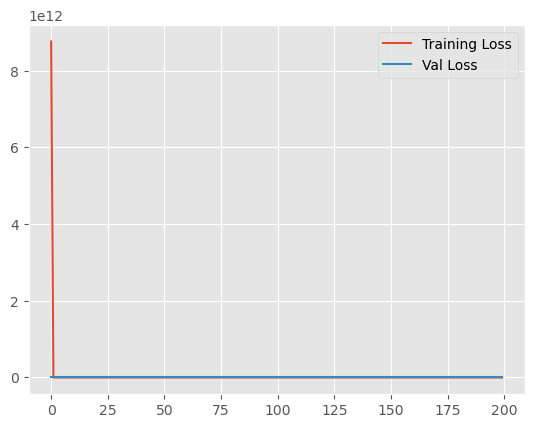

In [28]:
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Val Loss")
plt.legend()
plt.show()

In [29]:
start_time = time.time()

prediction_ResNet50=resnet50_model.predict(test_images_hsv_stacked)

end_time =  time.time()

print("prediction_time: ",end_time-start_time )

3/3 [==============================] - 1s 76ms/step
prediction_time:  0.5891234874725342


In [30]:
print("MSE: ",MSE_SKL(test_labels, prediction_ResNet50))
print("MAE: ",MAE_SKL(test_labels, prediction_ResNet50))

MSE:  848.0114098838565
MAE:  22.491525330884382


In [31]:
mae_ =MAE_TF(test_labels, prediction_ResNet50)

print("MAE: ",mae_)
print(mae_)

mae_list= list(mae_)

max_mae = max(mae_list)
min_mae = min(mae_list)
#mid_mae = 9.303155 ##Image_Index = 58
median_mae = np.median(mae_list)


max_mae_index    = mae_list.index(max_mae)
min_mae_index    = mae_list.index(min_mae)
#mid_mae_index    = mae_list.index(mid_mae)   
median_mae_index = mae_list.index(median_mae)

print("Max Error: {} , Index of Max Error: {}".format(max_mae , max_mae_index))
print("Min Error: {} , Index of Min Error: {}".format(min_mae , min_mae_index))
print("Median Error: {} , Index of Median Error: {}".format(median_mae , median_mae_index))



MAE:  tf.Tensor(
[36.878887 17.609116  9.56084  35.17236  16.79947  54.74784  60.774864
 57.114086 42.00588  36.565037  8.038062 49.147903 30.937284 10.810731
  9.764373 12.287828 36.184315 45.942394 37.66759   9.457152 27.127975
 24.555592 16.085663 16.04046  34.60346   9.44675  17.098768 17.098768
 31.666744 11.201054 11.626304 29.65848  29.560236 12.695238 33.565765
 17.44139  19.15623   9.603606  9.796595 37.45517  21.417776 20.786198
 13.666562 12.870044 12.783044 23.974283  4.253839  4.048004 21.804762
 41.135235 41.108917 12.631963 17.121714 10.971839  8.884865 12.538842
 11.431054 10.44469  10.961911 13.525818 13.23601  24.842999 34.77026
 26.721579 27.353329 11.917473  8.778931], shape=(67,), dtype=float32)
tf.Tensor(
[36.878887 17.609116  9.56084  35.17236  16.79947  54.74784  60.774864
 57.114086 42.00588  36.565037  8.038062 49.147903 30.937284 10.810731
  9.764373 12.287828 36.184315 45.942394 37.66759   9.457152 27.127975
 24.555592 16.085663 16.04046  34.60346   9.44675 

[112.04097  355.84448  142.40248  354.1171   174.34036  366.9992
 112.87052  370.4683   142.81703  381.46884  170.98717  391.43738
 110.14252  398.7559   173.96115  415.93057  107.10884  427.12955
 139.50735  428.0733   170.74109  442.38235  105.677635 440.92722
 135.18309  455.37473  162.95139  467.6017   101.36117  468.1943
 162.6142   490.75104   95.222305 496.17258  127.86671  500.23373
 157.11884  515.7779  ]
[112.04097  355.84448  142.40248  354.1171   174.34036  366.9992
 112.87052  370.4683   142.81703  381.46884  170.98717  391.43738
 110.14252  398.7559   173.96115  415.93057  107.10884  427.12955
 139.50735  428.0733   170.74109  442.38235  105.677635 440.92722
 135.18309  455.37473  162.95139  467.6017   101.36117  468.1943
 162.6142   490.75104   95.222305 496.17258  127.86671  500.23373
 157.11884  515.7779  ]
[112.04097  355.84448  142.40248  354.1171   174.34036  366.9992
 112.87052  370.4683   142.81703  381.46884  170.98717  391.43738
 110.14252  398.7559   173.96115 

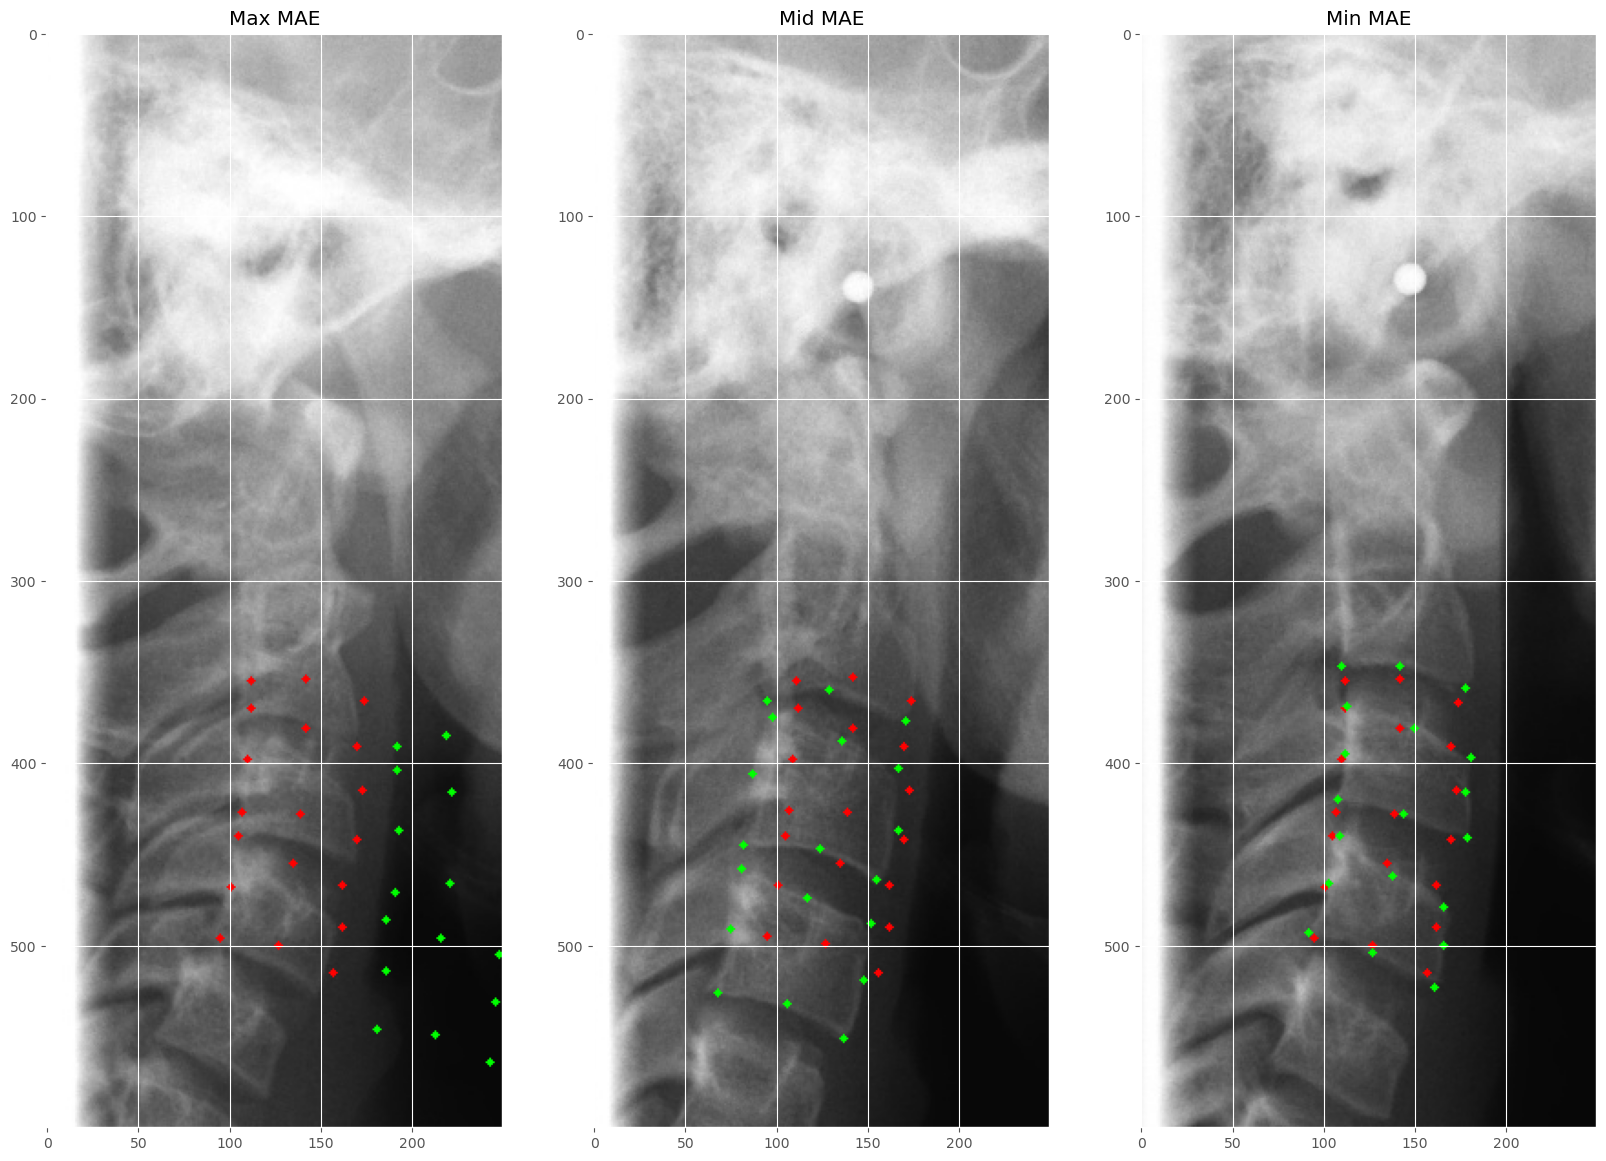

In [35]:

fig = plt.figure(figsize=(20, 20))
rows = 1
columns = 3

for j ,img_number,title in zip(range(1,4),[max_mae_index,median_mae_index,min_mae_index],["Max MAE","Mid MAE","Min MAE"]):
    img =np.copy(test_images[img_number])
    for i in range(0,38,2):
            print(prediction_ResNet50[img_number])
            img_ = cv2.circle(img,(int(prediction_ResNet50[img_number][i]),int(prediction_ResNet50[img_number][i+1])), 2, (255,0,0),-1)
            img_ = cv2.circle(img,(int(test_labels[img_number][i]),int(test_labels[img_number][i+1])), 2, (0,255,0),-1)
    fig.add_subplot(rows, columns, j)
    plt.imshow(img_)
    plt.title(title)


In [33]:
resnet50_model.save('resnet50_adabtiveLR_200_enhanced.h5')